# Fraud Detection Using GNNs

## What is fraud detection ?

Fraud detection is the process of identifying and preventing unauthorized activity in organizations. It has become a major challenge for companies in industries such as banking, finance, retail, and e-commerce. Fraud can negatively impact an organization's financial performance and reputation, making it crucial for companies to prevent and predict suspicious activity.



## Complex and evolving fraud patterns 

Fraudsters continually revise their strategies and devise ever-more-sophisticated methods to cheat the system, regularly involving intricate networks of transactions to prevent recognition. Traditional rule-based systems and matrix-based ML such as SVMs and XGBoost often just ponder the immediate edges of a deal (who transferred money to whom), usually omitting to notice fraudulent patterns with more complicated context. Rule-based systems furthermore need to be manually adjusted as fraud patterns shift and new scams arise.


## Label Quality

The datasets for fraud detection are commonly unbalanced and incompletely labeled. In reality, only a tiny fraction of people plan to perpetrate fraud. Usually, domain specialists will label transactions as fraudulent or not, but they can't make certain that all fraud has been identified in the dataset.

The large disparity between the number of labels and the amount of data available renders it hard to generate supervised models. Models trained on the accessible classifications could have a greater number of false negatives, while the imbalanced dataset could lead to an increase in false positives. Consequently, training Graph Neural Networks (GNNs) with different objectives and making use of their latent representations afterwards can be advantageous.


## Model explainability 

Predicting if a transaction is fraudulent or not is inadequate for meeting the transparency standards of the banking sector. It is also essential to comprehend why certain deals are marked as deceitful. This explicability is critical for comprehending how fraud occurs, how to execute procedures to reduce fraud, and to make sure the process isn’t prejudiced. As a result, fraud detection models must be comprehensible and interpretable, which restricts the choices of models that investigators can apply.

## Graph approaches for fraud detection

Transactions can be represented as a graph, with users as nodes and interactions between them as edges. Traditional feature-based algorithms such as XGBoost and DLRM analyze individual nodes or edges, while graph-based approaches take into account the local context and structure of the graph, including neighboring nodes and edges.

In the traditional graph domain, there are various methods for making predictions based on graph structure, such as statistical approaches that aggregate features from adjacent nodes or edges. Algorithms like the [Louvain method](https://en.wikipedia.org/wiki/Louvain_method) and [InfoMap](https://towardsdatascience.com/infomap-algorithm-9b68b7e8b86) can identify communities and clusters of users on the graph. However, these methods lack the expressivity to fully consider the graph in its original format.

Graph neural networks (GNNs) offer a solution by representing local structural and feature context natively within the model. Through aggregation and message passing, information from both edges and nodes is propagated to neighboring nodes. Multiple layers of graph convolution result in a node's state containing information from nodes multiple layers away, effectively allowing the GNN to have a "receptive field" of nodes or edges multiple jumps away from the node or edge in question.

For fraud detection, GNNs can account for complex or longer chains of transactions that fraudsters use for obfuscation. Additionally, changing patterns can be addressed by retraining the model iteratively.

## ML for graph 

These are the general steps of ML on Graph, depending on the task, the methods used in each step may change and not all the steps may be needed.

1. Graph Representation: The first step in applying machine learning techniques to graphs is to represent the graph in a format that can be input into a machine learning model. This can be done using various graph representations such as adjacency matrices, adjacency lists, and edge lists.

2. Feature Extraction: Once the graph is represented, the next step is to extract features from the graph that can be used as input to a machine learning model. These features can include things like node degree, centrality measures, and graph traversal patterns.

3. Dimensionality Reduction: As the number of nodes and edges in a graph can be large, it is often necessary to reduce the dimensionality of the graph representation before applying machine learning techniques. This can be done using techniques like principal component analysis (PCA) and t-SNE.

4. Model Selection: After the graph is represented and features have been extracted, the next step is to select a machine learning model that can be applied to the graph data. Common models used for graph data include decision trees, random forests, and neural networks.

5. Training and Evaluation: Once the model is selected, it is trained on the graph data using a labeled training dataset. The model is then evaluated on a separate test dataset to assess its performance.

6. Predictions: After the model is trained, it can be used to make predictions on new graph data. For example, it can be used to predict the likelihood of a node in a graph being in a certain class or to predict the likelihood of a link between two nodes.

## Dataset 
The IBM credit card transaction dataset is a publicly available dataset that contains information about credit card transactions. It is often used for research and testing of fraud detection models. The dataset includes a variety of features such as the amount of the transaction, the type of card used, and the location of the transaction. It also includes a label indicating whether or not the transaction was fraudulent. The dataset is designed to be representative of real-world transactions and therefore contains a certain level of class imbalance, with a higher number of non-fraudulent transactions than fraudulent transactions. The dataset is provided by IBM and the data is simulated, but it is not specified the exact process of data simulation. It is important to note that the data is not real and it is not linked to any real customer or financial institution.

The data set contains: 
* 24 million unique transactions
* 6,000 unique merchants
* 100,000 unique cards
* 30,000 fraudulent samples (0.1% of total transactions)

**Where to find the data** 
* If you are willing to use the data locally you can download it from this [link](https://ibm.ent.box.com/v/tabformer-data)
* In our case we will use Kaggle to create our GNN model so we are using the dataset on kaggle, here's the [link](https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions)

## Necessary imports 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

## Preprosessing 

Preprocessing tabular data before creating a graph is important because it ensures that the data is in a format that can be easily converted into a graph structure. Tabular data, such as a CSV file, typically contains rows and columns of information, with each row representing a single record and each column representing a specific feature or attribute. Before creating a graph, it is essential to clean and transform the data so that it is consistent and in a format that can be easily mapped to a graph structure. This may include tasks such as filling in missing values, converting data types, and removing duplicates.

Additionally, preprocessing tabular data can also help to improve the performance and accuracy of graph-based algorithms by reducing noise and irrelevant information in the data. This can be achieved by removing irrelevant features, normalizing numerical data, and encoding categorical data. Preprocessing can also help to balance the class distribution in case of imbalanced data, which is a common problem in fraud detection datasets.

**Note:**

For hardware limitations we will only take 100.000 samples of our data.

In [2]:
# Load the tabular dataset
df = pd.read_csv("/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv").sample(n=100000, random_state=42)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 18199893 to 4816941
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   User            100000 non-null  int64  
 1   Card            100000 non-null  int64  
 2   Year            100000 non-null  int64  
 3   Month           100000 non-null  int64  
 4   Day             100000 non-null  int64  
 5   Time            100000 non-null  object 
 6   Amount          100000 non-null  object 
 7   Use Chip        100000 non-null  object 
 8   Merchant Name   100000 non-null  int64  
 9   Merchant City   100000 non-null  object 
 10  Merchant State  88782 non-null   object 
 11  Zip             88134 non-null   float64
 12  MCC             100000 non-null  int64  
 13  Errors?         1576 non-null    object 
 14  Is Fraud?       100000 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 12.2+ MB


In [4]:
# We need to make sure that the samples we extracted have some rows where fraud is True
df [df['Is Fraud?'] == 'Yes'].shape

(117, 15)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

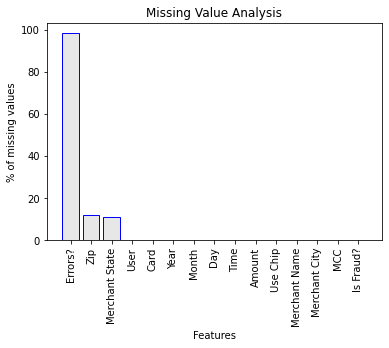

In [5]:
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

The card_id is defined as one card by one user. A specific user can have multiple cards, which would correspond to multiple different card_ids for this graph. 
For this reason we will create a new column which is the concatenation of the column User and the Column Card

In [6]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [7]:
df.Amount.head(5)

18199893      $59.18
9731325      $280.91
536687      $-144.00
13223840       $6.76
17070521       $9.17
Name: Amount, dtype: object

In [8]:
# We need to strip the ‘$’ from the Amount to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [9]:
# time can't be casted to int so so opted to extract the hour and minute
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [10]:
df.Hour

18199893    00
9731325     22
536687      07
13223840    14
17070521    11
            ..
3028639     20
11275290    14
1327632     11
2929345     09
4816941     11
Name: Hour, Length: 100000, dtype: object

In [11]:
df.Minute

18199893    11
9731325     12
536687      07
13223840    58
17070521    44
            ..
3028639     37
11275290    12
1327632     15
2929345     51
4816941     08
Name: Minute, Length: 100000, dtype: object

In [12]:
df = df.drop(["Time","User","Card"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 18199893 to 4816941
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Year            100000 non-null  int64  
 1   Month           100000 non-null  int64  
 2   Day             100000 non-null  int64  
 3   Amount          100000 non-null  float64
 4   Use Chip        100000 non-null  object 
 5   Merchant Name   100000 non-null  int64  
 6   Merchant City   100000 non-null  object 
 7   Merchant State  88782 non-null   object 
 8   Zip             88134 non-null   float64
 9   MCC             100000 non-null  int64  
 10  Errors?         1576 non-null    object 
 11  Is Fraud?       100000 non-null  object 
 12  card_id         100000 non-null  object 
 13  Hour            100000 non-null  object 
 14  Minute          100000 non-null  object 
dtypes: float64(2), int64(5), object(8)
memory usage: 12.2+ MB


In [13]:
df["Errors?"].unique()

array([nan, 'Bad PIN', 'Insufficient Balance', 'Technical Glitch',
       'Bad Card Number', 'Bad CVV', 'Bad Expiration', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch', 'Bad Card Number,Bad CVV',
       'Bad CVV,Insufficient Balance',
       'Bad Card Number,Insufficient Balance'], dtype=object)

In [14]:
df["Errors?"]= df["Errors?"].fillna("No error")

The two columns Zip and Merchant state contains missing values which can affect our graph. Moreover these information can be extracted from the column Merchant City so we will drop them.

In [15]:
df = df.drop(columns=["Merchant State","Zip"],axis=1)

In [16]:
# change the is fraud column to binary 
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [17]:
df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])

In [18]:
df["Errors?"].unique()

array([10,  6,  8, 11,  2,  0,  5,  7,  9,  3,  1,  4])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 18199893 to 4816941
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           100000 non-null  int64  
 1   Month          100000 non-null  int64  
 2   Day            100000 non-null  int64  
 3   Amount         100000 non-null  float64
 4   Use Chip       100000 non-null  int64  
 5   Merchant Name  100000 non-null  int64  
 6   Merchant City  100000 non-null  int64  
 7   MCC            100000 non-null  int64  
 8   Errors?        100000 non-null  int64  
 9   Is Fraud?      100000 non-null  int64  
 10  card_id        100000 non-null  object 
 11  Hour           100000 non-null  object 
 12  Minute         100000 non-null  object 
dtypes: float64(1), int64(9), object(3)
memory usage: 10.7+ MB


## GNN for fraud detection:
Creating a multigraph for fraud detection using transaction data and applying a Graph Neural Network (GNN) on the edge list can be done in the following steps:

1. Prepare the transaction data: Collect and organize the transaction data into a format that can be used to create the edges of the multigraph. For example, each transaction could be represented as a tuple (node1, node2, attributes), where node1 and node2 represent the sender and receiver of the transaction, and attributes is a dictionary containing properties such as the amount, timestamp, and transaction type.

2. Create the multigraph: Use the transaction data to create a multigraph using the NetworkX library. The add_edge() method can be used to add edges to the multigraph, where each edge represents a transaction.

3. Extract the edges list and their features: Use the edges() method of the multigraph to extract the edges list and their features, which will be used as input to the GNN.

4. Apply a GNN on the edge list: Use a GNN library such as PyTorch Geometric, Deep Graph Library (DGL) or Spektral to apply a GNN on the edge list. The GNN will learn representations of the edges in the multigraph and use them to classify the edges as fraudulent or non-fraudulent.

5. Evaluation: To evaluate the performance of the GNN, you can split the data into train and test sets, and use the test set to evaluate the accuracy, precision, recall, and F1-score of the model.

### Graph construction 

When constructing a graph with transaction edges between card_id and merchant_name, the first step is to identify the nodes in the graph. In this case, the card_id and merchant_name represent the nodes in the graph. Each card_id represents a unique credit card and each merchant_name represents a unique merchant. These nodes can be created by extracting the card_id and merchant_name information from the tabular data and storing them in separate lists.

Once the nodes have been identified, the next step is to create edges between them. These edges represent the transactions that have taken place between a card_id and a merchant_name. To create the edges, a list of transactions is created and for each transaction, an edge is created between the card_id and merchant_name.


### Method 1

We are creating an empty multigraph object called G using the nx.MultiGraph() function from the NetworkX library. Then we add nodes to the graph for each unique card_id and merchant_name from the dataframe df.

The add_nodes_from method is used to add nodes to the graph, it takes an iterable as input and creates a node for each element in the iterable. The df["card_id"].unique() will return a list of unique card_ids in the dataframe, and the df["Merchant Name"].unique will return a list of all the merchant names in the dataframe.

The type attribute is added to each node, it is used to differentiate between card_id and merchant_name nodes. This will help later on when we want to analyze the graph.

**Why did we use a multigraph and not graph?**

The same user (card_id) can buy from the same merchant (Merchant Name) multiple times, so we can have multiple edges between the user and the merchant and for this reason we used multigraph instead of graph 

  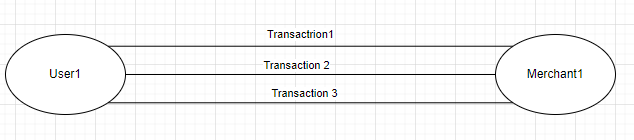


In [21]:
# Create an empty graph
G = nx.MultiGraph()

# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["card_id"].unique(), type='card_id')
G.add_nodes_from(df["Merchant Name"].unique(), type='merchant_name')


The code below adding edges and properties to the edges of a graph. The code iterates through each row of the dataframe, df, and creates a variable for each property then assign it to the edge between the card_id and merchant_name of that row.

In [22]:
# Add edges and properties to the edges 
for _, row in df.iterrows():
    # Create a variable for each properties for each edge
    
        year = row["Year"],
        month = row["Month"],
        day = row["Day"],
        hour = row["Hour"],
        minute =row["Minute"],
        amount = row["Amount"],
        use_chip =  row["Use Chip"],
        merchant_city = row["Merchant City"],
        errors =  row["Errors?"],
        mcc = row['MCC']
    
 
        G.add_edge(row['card_id'], row['Merchant Name'], year = year , month = month , day = day ,
              hour = hour , minute = minute , amount = amount , use_chip = use_chip ,
              merchant_city = merchant_city , errors = errors , mcc = mcc)
  


In [23]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 16415
Number of edges: 100000


In [25]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

In [26]:
adj_matrix.shape

(16415, 16415)

We will retrieve the properties of a small sample of **nodes** in our graph (G) and print their properties.

In [27]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')

# Print the properties of the sample nodes
for node in sample_nodes:
    print(f"Node: {node}, Properties: {node_properties[node]}")


Node: 1470_0, Properties: card_id
Node: 822_1, Properties: card_id
Node: 41_3, Properties: card_id
Node: 1084_0, Properties: card_id
Node: 1384_0, Properties: card_id
Node: 55_3, Properties: card_id
Node: 776_0, Properties: card_id
Node: 66_0, Properties: card_id
Node: 1880_2, Properties: card_id
Node: 490_5, Properties: card_id


In [28]:
sample_size = 5
for i, edge in enumerate(G.edges()):
    print(G.get_edge_data(*edge))
    if i >= sample_size - 1:
        break

{0: {'year': (2019,), 'month': (7,), 'day': (10,), 'hour': ('00',), 'minute': ('11',), 'amount': (59.18,), 'use_chip': (0,), 'merchant_city': (1890,), 'errors': (10,), 'mcc': 5813}, 1: {'year': (2019,), 'month': (10,), 'day': (1,), 'hour': ('00',), 'minute': ('22',), 'amount': (91.4,), 'use_chip': (0,), 'merchant_city': (1890,), 'errors': (10,), 'mcc': 5813}, 2: {'year': (2011,), 'month': (9,), 'day': (27,), 'hour': ('00',), 'minute': ('00',), 'amount': (64.21,), 'use_chip': (2,), 'merchant_city': (1890,), 'errors': (10,), 'mcc': 5813}, 3: {'year': (2011,), 'month': (11,), 'day': (11,), 'hour': ('00',), 'minute': ('04',), 'amount': (64.36,), 'use_chip': (2,), 'merchant_city': (1890,), 'errors': (10,), 'mcc': 5813}, 4: {'year': (2009,), 'month': (11,), 'day': (25,), 'hour': ('00',), 'minute': ('18',), 'amount': (52.75,), 'use_chip': (2,), 'merchant_city': (1890,), 'errors': (10,), 'mcc': 5813}}
{0: {'year': (2019,), 'month': (7,), 'day': (10,), 'hour': ('00',), 'minute': ('11',), 'amoun

We will retrieve the properties of a small sample of **edges** in our graph (G) and print their properties.

In [29]:
# Retrieve the properties errors of all the edges
edge_properties = nx.get_edge_attributes(G, 'errors')

# Count the number of edges by property value
edge_count_by_property = Counter(edge_properties.values())

# Print the count of edges by property value
for property_value, count in edge_count_by_property.items():
    print(f"Property value: {property_value}, Count: {count}")


Property value: (10,), Count: 98424
Property value: (8,), Count: 1003
Property value: (6,), Count: 228
Property value: (5,), Count: 44
Property value: (0,), Count: 42
Property value: (11,), Count: 195
Property value: (2,), Count: 50
Property value: (4,), Count: 2
Property value: (1,), Count: 1
Property value: (9,), Count: 3
Property value: (7,), Count: 7
Property value: (3,), Count: 1


In [30]:
# Prepare the data for input into the model
edge_list = list(G.edges(data=True))

In [31]:
list(edge_list[i][2].values())

[(2009,), (11,), (25,), ('00',), ('18',), (52.75,), (2,), (1890,), (10,), 5813]

We define a PyTorch neural network model called "FraudGNN" which is a type of Graph Neural Network. The model is a simple feedforward neural network with two fully connected (Linear) layers. The first layer has input_dim number of input units and hidden_dim number of output units, while the second layer has hidden_dim number of input units and 1 output unit.
The forward function of the model applies the linear layers to the input tensor "x" and applies a ReLU activation function to the output of the first linear layer.

We also prepare data for input into the model. We define the variable "edge_list" which is a list of edges and their associated data in a graph G. Then we create an empty list called "x" and iterates over each edge in the edge_list. For each edge, it extracts the values of the edge data, converts them to floats if needed, and append them to the list "x". Finally, we convert the list "x" to a PyTorch tensor with float datatype, which is ready to be input into the FraudGNN model.

In [51]:
class FraudGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FraudGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)

# Prepare the data for input into the model
edge_list = list(G.edges(data=True))
x = []
for edge in edge_list:
    edge_values = list(edge[2].values())
    edge_values = [float(i[0]) if type(i) == tuple and type(i[0]) == str else i[0] if type(i) == tuple else i for i in edge_values]
    x.append(edge_values)
x = torch.tensor(x, dtype=torch.float)

In [52]:
target = torch.tensor(df['Is Fraud?'].values, dtype=torch.float)

In [53]:
# Define the model
input_dim = len(x[0])
hidden_dim = 16
model = FraudGNN(input_dim, hidden_dim)
num_epochs=201

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [54]:
# Train the model
for i in range(num_epochs):
    # Forward pass
    output = model(x)
    # Compute the loss
    loss = criterion(output, target)
    if i % 20 == 0:
        print(f'Epoch: {i}, Loss: {loss.item()}')
    # Zero the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # Update the parameters
    optimizer.step()

Epoch: 0, Loss: 75.2183837890625
Epoch: 20, Loss: 2.2274389266967773
Epoch: 40, Loss: 2.2073874473571777
Epoch: 60, Loss: 1.6753615140914917
Epoch: 80, Loss: 0.3633090555667877
Epoch: 100, Loss: 0.2249840497970581
Epoch: 120, Loss: 0.15104109048843384
Epoch: 140, Loss: 0.08912204951047897
Epoch: 160, Loss: 0.07886513322591782
Epoch: 180, Loss: 0.0715927705168724
Epoch: 200, Loss: 0.0727226585149765


### Method 2 

In this part we will base our work on the [paper](https://www.sciencedirect.com/science/article/abs/pii/S0957417421017449) **Inductive Graph Representation Learning for fraud detection** written by RafaëlVan Belle, Charles Van Damme, Hendrik Tytgat and JochenDe Weerdt. 

Charles has created a python library with the name of inductiveGRL for the experimental setup of their paper. 

Library overview :

1. Transaction Data
Any dataset that can be transformed into a graph can be used in our experimental setup. For our research, we used a real-life dataset to construct credit card transaction networks containing millions of transactions. This dataset includes information on the following features: anonymized identification of clients and merchants, merchant category code, country, monetary amount, time, acceptance, and fraud label. This real-life dataset is highly imbalanced and contains only 0.65% fraudulent transactions. Note that the demo data in this repository is artificaly generated for demonstration purposes. The Timeframes component derives the different timeframes for a rolling window setup given a step and window size.

2. Graph Construction
The GraphConstruction component constructs the graphs that will be used by graph representation learners (e.g. FI-GRL and GraphSAGE) to learn node embeddings. We designed the credit card transaction networks as heterogeneous tripartite graphs containing client, merchant and transaction nodes. Because of this tripartite setup, representations can be learned for the transaction nodes. Only the transaction nodes are configured with node features.

3. GraphSAGE
The HinSAGE code deploys a supervised, heterogeneous implementation of the GraphSAGE framework called HinSAGE, to learn embeddings of the transaction nodes in the aforementioned graphs.

4. FI-GRL
The FIGRL code learns embeddings of the transaction nodes in the aforementioned graphs using the Fast Inductive Graph Representation Learning Framework. We call the Matlab implementation of FI-GRL from our Jupyter notebooks, which requires an appropriate installation of matlab.engine in the same folder as the notebooks. If you wish to run FI-GRL from Python, please run the following command in Matlab:

cd (fullfile(matlabroot,'extern','engines','python'))
system('python setup.py install')

This will generate a folder in matlabroot\extern\engines\python\build\lib called 'matlab' please copy this folder and place it on the same location as the notebook from which you want to call matlab.engine. If you don't know your matlab root, running 'matlabroot' in Matlab will return the appropriate path.

5. Classifier
The penultimate component in our pipeline uses the transaction node embeddings to classify the transaction nodes as fraudulent or legitimate. We chose to rely on XGBoost as a classification model, but other classifiers can easily be implemented.

6. Evaluation
The Evaluation component contains functions for the Lift score, Lift curve and precision-recall curve. We focused on these evaluation metrics given the highly imbalanced nature of our dataset. However, this code can easily be extended to contain other evaluation metrics such as ROC plots.

In [42]:
#library installation
!pip install inductiveGRL 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 757.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.2/217.2 kB 4.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 14.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 17.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follo

In [43]:
# necessary imports of this part
from inductiveGRL.graphconstruction import GraphConstruction
from inductiveGRL.hinsage import HinSAGE_Representation_Learner

2023-01-16 21:09:47.733429: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [44]:
# Global parameters:
embedding_size = 64
add_additional_data = True

We will split our data 70% to train_data and 30% for inductive data that will be used to test the model's ability to generalize to new, unseen data.

First we calculate the cutoff point for the split using the formula "cutoff = round(0.7*len(df))" where 0.7 represents 70% of the data, and len(df) is the total number of rows in the dataframe. The round function is used to round the cutoff point to the nearest whole number.

Second we assign the first "cutoff" rows of the dataframe to the variable "train_data" by calling the head() function on the dataframe and passing the cutoff point as an argument. These rows will be used as the training data.

Last we assign the remaining rows of the dataframe (the rows after the cutoff point) to the variable "inductive_data" by calling the tail() function on the dataframe and passing the number of remaining rows (len(df) - cutoff) as an argument. These rows will be used as the inductive data.

In [45]:
# we will take 70% of our dataset as traindata
cutoff = round(0.7*len(df)) 
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [46]:
print('The distribution of fraud for the train data is:\n', train_data['Is Fraud?'].value_counts())
print('The distribution of fraud for the inductive data is:\n', inductive_data['Is Fraud?'].value_counts())

The distribution of fraud for the train data is:
 0    69919
1       81
Name: Is Fraud?, dtype: int64
The distribution of fraud for the inductive data is:
 0    29964
1       36
Name: Is Fraud?, dtype: int64


#### Graphe construction 

We will create a graph from a train_data using the GraphConstruction class. First we create the dataframes for the node data, second we define the nodes and edges, third  we create a dictionary of features, and finally we create a graph object, and calls the get_stellargraph() method to get the StellarGraph object.

In [47]:
transaction_node_data = train_data.drop("card_id", axis=1).drop("Merchant Name", axis=1).drop('Is Fraud?', axis=1)
client_node_data = pd.DataFrame([1]*len(train_data["card_id"].unique())).set_index(train_data["card_id"].unique())
merchant_node_data = pd.DataFrame([1]*len(train_data["Merchant Name"].unique())).set_index(train_data["Merchant Name"].unique())

nodes = {"client":train_data.card_id, "merchant":train_data["Merchant Name"], "transaction":train_data.index}
edges = [zip(train_data.card_id, train_data.index),zip(train_data["Merchant Name"], train_data.index)]
features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}

graph = GraphConstruction(nodes, edges, features)
S = graph.get_stellargraph()
print(S.info())

StellarGraph: Undirected multigraph
 Nodes: 84186, Edges: 140000

 Node types:
  transaction: [70000]
    Features: float32 vector, length 10
    Edge types: transaction-default->client, transaction-default->merchant
  merchant: [9305]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction
  client: [4881]
    Features: float32 vector, length 1
    Edge types: client-default->transaction

 Edge types:
    merchant-default->transaction: [70000]
        Weights: all 1 (default)
        Features: none
    client-default->transaction: [70000]
        Weights: all 1 (default)
        Features: none


In [48]:
#GraphSAGE parameters
num_samples = [2,32]
embedding_node_type = "transaction"

hinsage = HinSAGE_Representation_Learner(embedding_size, num_samples, embedding_node_type)
trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(train_data.index), train_data['Is Fraud?'], batch_size=5, epochs=10)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2023-01-16 21:09:51.615930: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
11200/11200 [==============================] - 59s 5ms/step - loss: 0.0141 - val_loss: 0.0084
Epoch 2/10
11200/11200 [==============================] - 54s 5ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 3/10
11200/11200 [==============================] - 55s 5ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 4/10
11200/11200 [==============================] - 53s 5ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 5/10
11200/11200 [==============================] - 60s 5ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 6/10
11200/11200 [==============================] - 57s 5ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 7/10
11200/11200 [==============================] - 58s 5ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 8/10
11200/11200 [==============================] - 57s 5ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 9/10
11200/11200 [==============================] - 60s 5ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 10/10
11200/11200 [==============================

## Bibliogtaphy : 

**Papers** 

Inductive Graph Representation Learning for fraud detection (paper)  : [Link](https://www.sciencedirect.com/science/article/abs/pii/S0957417421017449)

Intelligent Financial Fraud Detection Practices: An
Investigation : [Link](https://arxiv.org/ftp/arxiv/papers/1510/1510.07165.pdf)

Modeling Relational Data with Graph Convolutional Networks : [Link](https://arxiv.org/pdf/1703.06103.pdf) 

For more papers check this github [link](https://github.com/benedekrozemberczki/awesome-fraud-detection-papers)

**Library** 

Inductive-Graph-Representation-Learning-for-Fraud-Detection (library) : [Link](https://github.com/Charlesvandamme/Inductive-Graph-Representation-Learning-for-Fraud-Detection)

**Dataset** 

IBM dataset : 
* [Link1](https://github.com/IBM/TabFormer) github
* [Link2](https://ibm.ent.box.com/v/tabformer-data) IBM@Box
* [Link3](https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions) kaggle

**Others** 

11 Categorical Encoders and Benchmark : [Link](https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark#1.-Label-Encoder-(LE),-Ordinary-Encoder(OE)) 

StellarGraph : [Link](https://stellargraph.readthedocs.io/en/stable/README.html#example-gcn)

NetworkX : [Link](https://networkx.org)